Load libraries

In [145]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import random
import sys
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import MaxPooling3D


%matplotlib inline
%config IPCompleter.greedy=True

# Preprocessing:


Load images and change their height and width to a smaller scale so that it is efficient while computing.

In [146]:
imageShape=(32,32)

root_folder="/home/rajeev/Documents/DataSets/Kaggle/Whale"
root_train=root_folder+"/train/"
root_test=root_folder+"/test/"

def readFormattedImages(rootFolder,imageShape):
    '''
    This function reads all the images in specified 'rootFolder' and converts them to new shape of 'imageShape'
    
    Returns: 
        X_images: Ndarray of shape(image count, image height, image width, channels)
        labels: A list consisting of names of each image. Name contains .jpg as well.
    '''
    img_names=os.listdir(rootFolder)
    #Read images and convert them to square of shape(image_height,image_width,3)
    images=[]
    labels=[]
    for img_name in img_names:
        img=cv2.imread(rootFolder+img_name,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,imageShape)
        images.append(img)
        labels.append(img_name)
    X_images=np.reshape(images,(len(images),imageShape[0],imageShape[1]))
    return X_images,labels


Create a function for maxpooling. This function takes a kernel size and stride and for each kernel operation performs max pooling.

In [147]:
def maxPool(ndArray,kernel=(2,2),stride=(2,2),poolingMethod="max"):
    #print("img shape",ndArray.shape)
    m,n=ndArray.shape
    maxList=[]
    #print(list(range(0,n,stride[0])))
    for i in range(0,m,stride[0]):
        for j in range(0,n,stride[1]):        
            subArr=ndArray[i:i+kernel[0],j:j+kernel[1]]
            #print(i,j,subArr)
            pooledValue=0
            if(poolingMethod=='max'):
                pooledValue=subArr.max()
            elif(poolingMethod=='min'):
                pooledValue=subArr.min()
            elif(poolingMethod=='mean'):
                pooledValue=subArr.mean()
            maxList.append(pooledValue)
    outputHeight=int(((m-kernel[0])/stride[0])+1)
    outputWidth=int(((n-kernel[1])/stride[1])+1)
    outputArr=np.reshape(maxList,(outputHeight,outputWidth))
    return outputArr
            

Now load mappings between image name and image id from train.csv file.

In [148]:
#id_to_name=dict()
name_to_id=dict()
count=0
with open(root_folder+"/train.csv", newline='') as csvFile:
    idReader = csv.reader(csvFile, delimiter=',', quotechar='|')
    for row in idReader:
        #id_to_name[row[1]]=row[0]
        name_to_id[row[0]]=row[1]
        count+=1
id_to_int=dict()
index=0
for id_x in name_to_id.values():
    if id_x not in id_to_int:
        id_to_int[id_x]=index
        index += 1
int_to_id=dict((intVal,imgID) for imgID,intVal in id_to_int.items())
print("Created numeric indicies for image ids ",len(id_to_int))

Created numeric indicies for image ids  4252


Load train and test images.

In [149]:
X_train,X_train_labels=readFormattedImages(root_train,imageShape)
print(len(X_train),"training images and ",len(X_train_labels)," training labels")
X_test,X_test_labels=readFormattedImages(root_test,imageShape)
print(len(X_test),"test images")


9850 training images and  9850  training labels
15610 test images


Convert labels from image names to image ids. Use 'name_to_id' dictionary for this conversion.

In [150]:
#Convert labels from image names to image ids.
X_train_ids=[id_to_int[name_to_id[name]] for name in X_train_labels]
X_train_ids=np.array(X_train_ids)
#print(X_train_ids)
#print(X_train_ids.shape,min(X_train_ids))

Y_train=np.zeros(shape=(X_train_ids.shape[0],max(X_train_ids)+1))
Y_train[np.arange(X_train_ids.shape[0]),X_train_ids]=1.0
#print(len(X_train_labels),len(X_train_ids))
#print(Y_train.shape)
#print(max(Y_train[0,:]))
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)

X_train (9850, 32, 32)
Y_train (9850, 4252)


Binarized X_train.shape (9850, 32, 32)
Binarized X_test.shape (15610, 32, 32)
show binarized train img samples.


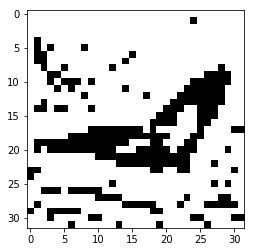

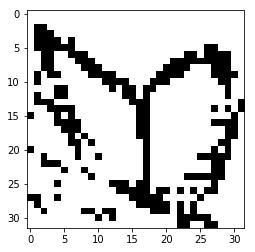

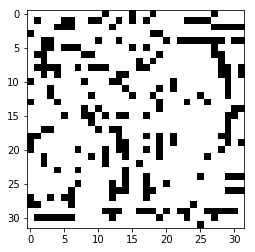

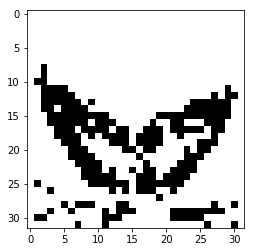

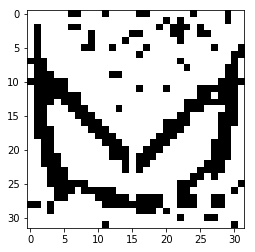

show binarized test img samples.


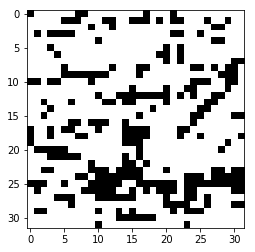

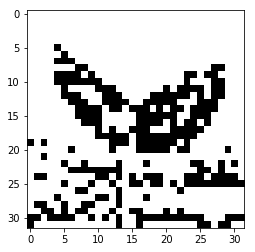

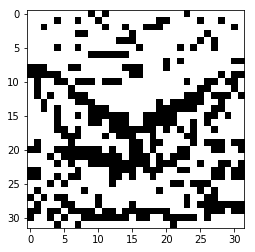

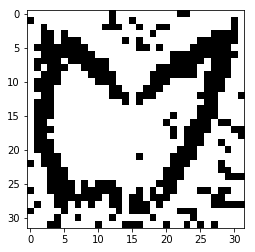

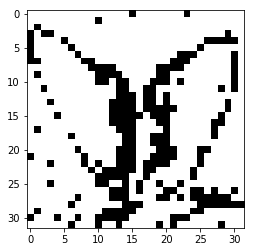

In [151]:
def binarizeImgs(imgNDArray):
    output=[]
    for img in imgNDArray:
        th=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,16)
        output.append(th)
    output=np.array(output)
    output=np.reshape(output,imgNDArray.shape)
    return output

X_train_bin=binarizeImgs(X_train)
X_test_bin=binarizeImgs(X_test)
print("Binarized X_train.shape",X_train_bin.shape)
print("Binarized X_test.shape",X_test_bin.shape)


print("show binarized train img samples.")
for img in X_train_bin[:5]:
    plt.imshow(img,cmap="gray")
    plt.show()
    
print("show binarized test img samples.")
for img in X_test_bin[:5]:
    plt.imshow(img,cmap="gray")
    plt.show()


Now scale values of images by dividing all values by 255.
Also convert training labels to one hot encoded format.

In [152]:
#X_train=X_train_bin
#X_test=X_test_bin

X_train=X_train/255
X_test=X_test/255

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)

X_train (9850, 32, 32)
Y_train (9850, 4252)


Now do max pooling of images.

In [153]:
def maxPoolImgList(imgList,outputShape,kernel,stride,poolingMethod="max"):
    '''
    Params:
    imgList: Numpy array of images.
    outputShape: shape of output image list.
    kernel: 2-D kernel.
    stride: 2-D stride.
    
    Returns:
    pooledImgs: Numpy array of pooled images. Shape of 'pooledImgs'=outputShape
    '''
    pooledImgs=[]
    for index,img in enumerate(imgList):
        pooledImg=None
        if(outputShape[-1]==3):
            r=maxPool(img[:,:,0],kernel,stride,poolingMethod)
            g=maxPool(img[:,:,1],kernel,stride,poolingMethod)
            b=maxPool(img[:,:,2],kernel,stride,poolingMethod)
            maxPooledImg=np.dstack((r,g,b))
        else:
            maxPooledImg=maxPool(img,kernel,stride,poolingMethod)
        #print(maxPooledImg.shape)
        pooledImgs.append(maxPooledImg)
        if(index%1000==0):
            print("Maxpooled",index,"/",X_train.shape[0],"imgs")    
    pooledImgs=np.array(pooledImgs)
    pooledImgs=np.reshape(pooledImgs,outputShape)
    return pooledImgs

print("Max pooling train imgs")
#X_train_maxpooled=[maxPool(img,kernel=(4,4),stride=(4,4)) for img in X_train]
#X_train_maxpooled=np.reshape(X_train_maxpooled,(8,8))
poolingMethod="max"
print("Train: before pooling shape",X_train.shape)
outputShapeTrain=(X_train.shape[0],8,8)
X_train_pooled=maxPoolImgList(X_train,outputShapeTrain,kernel=(4,4),stride=(4,4),poolingMethod=poolingMethod)
print("Train: after pooling shape",X_train_pooled.shape)

print("Max pooling test imgs")
print("Test: before pooling shape",X_test.shape)
outputShapeTest=(X_test.shape[0],8,8)
X_test_pooled=maxPoolImgList(X_test,outputShapeTest,kernel=(4,4),stride=(4,4),poolingMethod=poolingMethod)
print("Test: after pooling shape",X_test_pooled.shape)

Max pooling train imgs
Train: before pooling shape (9850, 32, 32)
Maxpooled 0 / 9850 imgs
Maxpooled 1000 / 9850 imgs
Maxpooled 2000 / 9850 imgs
Maxpooled 3000 / 9850 imgs
Maxpooled 4000 / 9850 imgs
Maxpooled 5000 / 9850 imgs
Maxpooled 6000 / 9850 imgs
Maxpooled 7000 / 9850 imgs
Maxpooled 8000 / 9850 imgs
Maxpooled 9000 / 9850 imgs
Train: after pooling shape (9850, 8, 8)
Max pooling test imgs
Test: before pooling shape (15610, 32, 32)
Maxpooled 0 / 9850 imgs
Maxpooled 1000 / 9850 imgs
Maxpooled 2000 / 9850 imgs
Maxpooled 3000 / 9850 imgs
Maxpooled 4000 / 9850 imgs
Maxpooled 5000 / 9850 imgs
Maxpooled 6000 / 9850 imgs
Maxpooled 7000 / 9850 imgs
Maxpooled 8000 / 9850 imgs
Maxpooled 9000 / 9850 imgs
Maxpooled 10000 / 9850 imgs
Maxpooled 11000 / 9850 imgs
Maxpooled 12000 / 9850 imgs
Maxpooled 13000 / 9850 imgs
Maxpooled 14000 / 9850 imgs
Maxpooled 15000 / 9850 imgs
Test: after pooling shape (15610, 8, 8)


Use pooled images as actual train and test images.

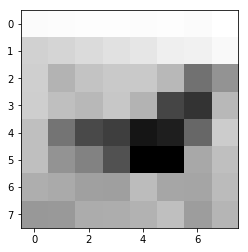

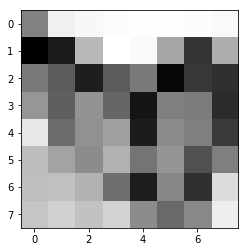

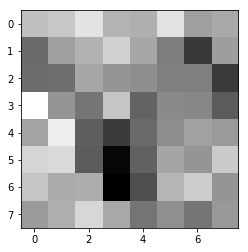

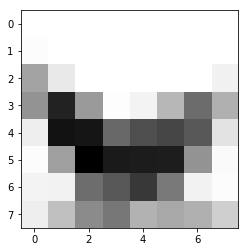

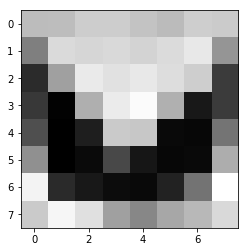

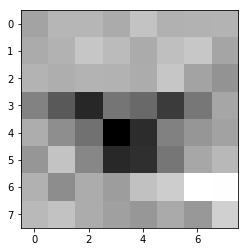

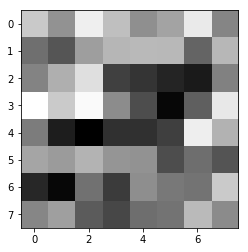

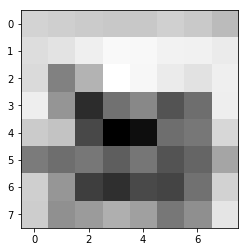

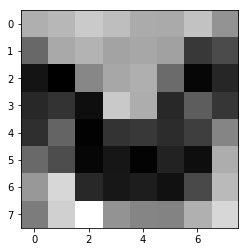

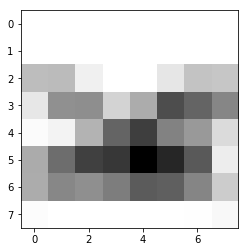

In [154]:

for img in X_train_pooled[:10]:
    #print(img)
    plt.imshow(img,cmap="gray")
    plt.show()

In [155]:
#unique, counts = np.unique(X_train_ids, return_counts=True)
#print("unique",len(unique),"counts",len(counts),max(counts),min(counts))
#print(list(zip(unique,counts)))
#plt.plot(unique,counts)
#plt.show()

# Modelling:

### 1. KNN:
Using k-Nearest neighbours for similarity matching.

In [156]:
def euclidianSim(arr1,arr2):
    arr1=np.reshape(arr1,(1,))
    arr2=np.reshape(arr2,(1,))
    diff=arr1-arr2
    norm=np.linalg.norm(diff)
    return norm

def cosineSim(arr1,arr2):
    arr1=np.reshape(arr1,(-1,1))
    arr2=np.reshape(arr2,(-1,1))
    norm1=np.linalg.norm(arr1)
    norm2=np.linalg.norm(arr2)
    cosineSimilarity=float((np.dot(np.transpose(arr1),arr2))/(norm1*norm2))
    return cosineSimilarity
    


def knn(testImg,trainExamples,trainLabels,K=100,similarityMeasure="euclidian"):
    #print("Executing KNN for k",K)
    #Club train examples and labels together.
    zipped=zip(trainExamples,trainLabels)
    prediction=[]
    for trainImg,label in zipped:
        #sub=np.subtract(trainImg,testImg)
        #print(testImg.shape,trainImg.shape,sub.shape)
        #sub=np.reshape(sub,(-1,1))
        #print(testImg.shape,trainImg.shape,sub.shape)
        #fibNorm=np.linalg.norm(sub,ord="fro")
        similarity=0
        if(similarityMeasure=="euclidian"):
            similarity=euclidianSim(trainImg,testImg)
        elif(similarityMeasure=="cosine"):
            similarity=cosineSim(trainImg,testImg)
        result=(label,similarity)
        prediction.append(result)
    #Take top-K similarities.
    topPrediction=sorted(prediction,key=lambda x: -x[1])[:K]
    topIds=[imgID for imgID,sim in topPrediction]
    return topIds
    #unique,counts=np.unique(topIds,return_counts=True)
    #uniqueZipped=list(zip(unique,counts))
    #print(uniqueZipped[:3])
    #classFreqs=sorted(uniqueZipped, key=lambda x: -x[1])
    #top 5 classes
    #print("top 5 ",classFreqs[:5])
    #return classFreqs[:5] #List of tuples(id,count)
   

def computeBestK(validationImgs,validationLabels,trainExamples,trainLabels,K=100,similarityMeasure="euclidian"):
    predictions=[]
    totalValidationLen=validationImgs.shape[0]
    for i in range(0,totalValidationLen):
        validationImg=validationImgs[i]
        validationLabel=validationLabels[i]
        predictionList=knn(validationImg,trainExamples,trainLabels,K,similarityMeasure)
        predictions.append((validationLabel,predictionList))
        if(i%100==0):
            sys.stdout.write("\nValidated"+str(i)+"/"+str(totalValidationLen)+"images")
        sys.stdout.write(".")
    print("Validation complete.")
    bestK=0
    bestSuccessCount=0
    for k in range(5,K,5): 
        successCount=0
        for imgID,predList in predictions:
            unique,counts=np.unique(predList[:k],return_counts=True)
            uniqueZipped=list(zip(unique,counts))
            classFreqs=sorted(uniqueZipped, key=lambda x: -x[1])
            topClassID=classFreqs[0][0]
            if topClassID==imgID:
                successCount += 1
        print("Accuracy for k=",k,"is",(successCount/totalValidationLen))
        if(successCount>bestSuccessCount):
            bestSuccessCount=successCount
            bestK=k
            print("K updated to",bestK)
            
    #return predictions
    return bestK




Get top K predictions for each training image.

In [157]:
X_train=X_train_pooled
X_test=X_test_pooled
similarity_measure="cosine"

#Get top neighbours for each train image.
k=computeBestK(X_train,X_train_ids,X_train,X_train_ids,K=1000,similarityMeasure=similarity_measure)

#iterations=10
#for i in range(0,10):
#    indicies=list(range(0,X_train.shape[0]))
#    random.shuffle(indicies)

    #testPercent=0.2
    #testSize=int(X_train.shape[0]*testPercent)
#    validationSize=1000
    #print(testSize)
#    X_valid_imgs=X_train[indicies[0:validationSize]]
#    X_valid_ids=X_train_ids[indicies[0:validationSize]]

#    print(X_valid_imgs.shape,X_valid_ids.shape)
#    validationPredictions=computeTopKPredictions(X_valid_imgs,X_valid_ids,X_train,X_train_ids,K=1000)


Validated0/9850images....................................................................................................
Validated100/9850images....................................................................................................
Validated200/9850images....................................................................................................
Validated300/9850images....................................................................................................
Validated400/9850images....................................................................................................
Validated500/9850images....................................................................................................
Validated600/9850images....................................................................................................
Validated700/9850images....................................................................................................
Validated

Validated6500/9850images....................................................................................................
Validated6600/9850images....................................................................................................
Validated6700/9850images....................................................................................................
Validated6800/9850images....................................................................................................
Validated6900/9850images....................................................................................................
Validated7000/9850images....................................................................................................
Validated7100/9850images....................................................................................................
Validated7200/9850images....................................................................................................


Accuracy for k= 470 is 0.08223350253807106
Accuracy for k= 475 is 0.08223350253807106
Accuracy for k= 480 is 0.08223350253807106
Accuracy for k= 485 is 0.08223350253807106
Accuracy for k= 490 is 0.08223350253807106
Accuracy for k= 495 is 0.08223350253807106
Accuracy for k= 500 is 0.08223350253807106
Accuracy for k= 505 is 0.08223350253807106
Accuracy for k= 510 is 0.08223350253807106
Accuracy for k= 515 is 0.08223350253807106
Accuracy for k= 520 is 0.08223350253807106
Accuracy for k= 525 is 0.08223350253807106
Accuracy for k= 530 is 0.08223350253807106
Accuracy for k= 535 is 0.08223350253807106
Accuracy for k= 540 is 0.08223350253807106
Accuracy for k= 545 is 0.08223350253807106
Accuracy for k= 550 is 0.08223350253807106
Accuracy for k= 555 is 0.08223350253807106
Accuracy for k= 560 is 0.08223350253807106
Accuracy for k= 565 is 0.08223350253807106
Accuracy for k= 570 is 0.08223350253807106
Accuracy for k= 575 is 0.08223350253807106
Accuracy for k= 580 is 0.08223350253807106
Accuracy fo

In [158]:
print("bestK",k)

bestK 5


In [159]:

bestK=10


testData=list(zip(X_test,X_test_labels))
#print(int_to_id)
rows=["Image,Id"]
rowCount=0
totalRows=len(testData)
for testImg,label in testData:
    topIds=knn(testImg,X_train,X_train_ids,bestK,similarityMeasure=similarity_measure)
    unique,counts=np.unique(topIds[:bestK],return_counts=True)
    uniqueZipped=list(zip(unique,counts))
    classFreqs=sorted(uniqueZipped, key=lambda x: -x[1])
    classIntIDs=[int_to_id[classIntID] for classIntID,count in classFreqs[:5]]
    
    
    #topClassID=classFreqs[0][0]
    #result1=[int_to_id[imgID] for imgID,_ in result]
    classes=" ".join(classIntIDs)
    row=label+","+classes
    #print(row)
    rows.append(row)
    rowCount+=1
    if(rowCount%100==0):
        print("Evaluated",rowCount,"/",totalRows,"test examples.")
    
submissionFile="/home/rajeev/Documents/DataSets/Kaggle/Whale/actual_submission.csv"

try:
    os.remove(submissionFile)
except OSError:
    print(OSError)
    pass


with open(submissionFile, mode="wt", encoding="utf-8") as myFile:
    myFile.write("\n".join(rows))
print("Output written to file ",submissionFile)
#for testImg in X_test:    
#    knn(testImg,X_train)

#lst=[(1,0.5),(1,2.5),(2,5),(2,0.005)]
#lst=sorted(lst,key=lambda x: -x[1])
#print(lst)


Evaluated 100 / 15610 test examples.
Evaluated 200 / 15610 test examples.
Evaluated 300 / 15610 test examples.
Evaluated 400 / 15610 test examples.
Evaluated 500 / 15610 test examples.
Evaluated 600 / 15610 test examples.
Evaluated 700 / 15610 test examples.
Evaluated 800 / 15610 test examples.
Evaluated 900 / 15610 test examples.
Evaluated 1000 / 15610 test examples.
Evaluated 1100 / 15610 test examples.
Evaluated 1200 / 15610 test examples.
Evaluated 1300 / 15610 test examples.
Evaluated 1400 / 15610 test examples.
Evaluated 1500 / 15610 test examples.
Evaluated 1600 / 15610 test examples.
Evaluated 1700 / 15610 test examples.
Evaluated 1800 / 15610 test examples.
Evaluated 1900 / 15610 test examples.
Evaluated 2000 / 15610 test examples.
Evaluated 2100 / 15610 test examples.
Evaluated 2200 / 15610 test examples.
Evaluated 2300 / 15610 test examples.
Evaluated 2400 / 15610 test examples.
Evaluated 2500 / 15610 test examples.
Evaluated 2600 / 15610 test examples.
Evaluated 2700 / 1561